**TRABAJO PRÁCTICO FINAL**

Materia: Procesamiento de Lenguaje Natural

Alumno: Francisco Domingo

Año: 2024

# Environment Setup #

En esta sección realizaremos todas las configuraciones iniciales, incluídas las instalaciones de librerías, para poder ejecutar el código correctamente.

In [1]:
!pip install redis
!pip install redisgraph
!pip install networkx matplotlib

!pip uninstall protobuf -y
!pip install protobuf==3.20.3
!pip install tensorflow==2.17.1 tensorflow-metadata==1.13.1 protobuf==3.20.3 chromadb==0.5.23
!pip install chromadb sentence-transformers

!pip install gdown
!pip install PyPDF2
!pip install youtube-transcript-api
!pip install langchain
!pip install -U langchain-community

!apt-get remove -y chromium-browser chromium-chromedriver
!rm -f /usr/bin/chromedriver

!pip install selenium
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!ln -s /usr/lib/chromium-browser/chromedriver /usr/bin/chromedriver

!pip install wikidata
!pip install langdetect
!pip install deep_translator

!pip install llama-index --upgrade
!pip install sentence-transformers --upgrade

!pip install python-decouple==3.8 llm-templates

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
  Using cached transformers-4.46.3-py3-none-any.whl.metadata (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.3/622.3 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3

In [2]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes

--2024-12-31 16:28:32--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.81, 185.125.190.82, 185.125.190.81, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318204 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  --.-KB/s    in 0.09s   

2024-12-31 16:28:33 (13.9 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’ saved [1318204/1318204]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 124099 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2) ...
debconf: unable to initialize frontend: Dialog
debcon

Importamos nuestras librerías, clases, métodos y funciones en la misma celda, para mantener el posterior código más limpio y claro.

In [1]:
import gdown
import os
import shutil
import re
import PyPDF2
import chromadb
import pandas as pd
import time
import requests
import networkx as nx
import redis
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# YouTube API
from youtube_transcript_api import YouTubeTranscriptApi

# Langchain to manage chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# Transformers
from sentence_transformers import SentenceTransformer

# Web Scrapping with Selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

# Graph DB
from redis import Redis
from redisgraph import Node, Edge, Graph

# Sklearn for machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# LLM with api key
from huggingface_hub import InferenceClient
from google.colab import userdata

# Language Manager
from langdetect import detect
from deep_translator import GoogleTranslator

# Plots
from matplotlib import rcParams


# Ejercicio 1: ChatBot #

En esta sección crearemos un chatbot especialado en el juego de mesa Rajas of the Ganjes. El objetivo es que este chatbot pueda responder preguntas acerca del juego, siendo capaz de categorizar las preguntas o inputs del usuario en diferentes categorías, para así usar múltiples bases de datos de forma dinámica, según el contenido que necesite en cada iteración.

El contexto para este modelo vendra en una de tres formas:

**Bases de datos vectorial**, generada a partir de documentos de textos, que contienen el reglamento y mecánicas del juego; y también a partir de transcripciones de videos de YouTube, que nos permita obtener información sobre las opiniones de los jugadores.

**Bases de datos en formato tabular**, generada a partir de hacer WebScrapping sobre la web de BoardGameGeek, para almacenar diferentes estadísticas del juego.

**Bases de datos de grafos**, generada a partir de WikiData y de hacer WebScrapping sobre la web de BoardGameGeek.

# Step 1: Content Download #

En este paso generaremos las tres bases de datos antes descriptas.

## Rules and Review: text ##

### Download PDF ###

Descargamos múltiples archivos pdf, entre los que se encuentra el reglamento oficial del juego, guías rápidas creadas por la comunidad, y la síntesis del reglamento generada por usuarios de la plataforma.

In [4]:
drive_folder_url = "https://drive.google.com/drive/folders/1bMK7C8qbU96FvUjOBT1D35wy1LZw3K4E?usp=sharing"

# Descarga carpeta 'game_data'
gdown.download_folder(drive_folder_url, quiet=True, output='game_data')

['game_data/Rajas_of_the_Ganges_-_rules_in_brief_v1.pdf',
 'game_data/Rajas_of_the_Ganges_Plain_and_Simple.pdf',
 'game_data/Rajas_of_the_Ganges_Quick_Rules_Guide.pdf',
 'game_data/Rajas_Player_Aid_v1.1.pdf',
 'game_data/rules_EN.pdf',
 'game_data/yago-tiny.ttl']

Extraer texto

Generamos funciones para la limpieza del texto: texto a minúsculas, remoción de signos y remoción de espaciado innecesario.

In [12]:
def remove_uppercase(x):
    x1 = x.lower()
    return x1

def remove_signs(x):
    x1 = re.sub(r'[^\w\s]', '', x)  # Elimina los signos, dejando solo palabras y espacios
    return x1.strip()

def remove_spaces(x):
    x1 = re.sub(r'\s+', ' ', x).strip()  # Reemplaza múltiples espacios con uno solo
    return x1

def clean_text(text):
    # Eliminar tabulaciones y dividir en oraciones
    text = text.replace("\t", "") #elimino tabs
    text = text.replace("\n", " ") #cambio saltos de línea por espacios

    # Aplicar las transformaciones en el orden correcto
    output = remove_uppercase(remove_signs(remove_spaces(text)))

    return output

Para cada uno de los archivos en formato PDF, extraemos su contenido de texto.

In [13]:
# Abre el archivo PDF
pdf_path = 'game_data/Rajas_of_the_Ganges_-_rules_in_brief_v1.pdf'
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    context1 = ''

    # Extrae el texto de cada página
    for page in reader.pages:
        context1 += page.extract_text()

In [14]:
doc1 = clean_text(context1)
print(f"Longitud de doc1: {len(doc1)}")

Longitud de doc1: 3542


In [15]:
# Abre el archivo PDF
pdf_path = 'game_data/Rajas_of_the_Ganges_Plain_and_Simple.pdf'
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    context2 = ''

    # Extrae el texto de cada página
    for page in reader.pages:
        context2 += page.extract_text()

In [16]:
doc2 = clean_text(context2)
print(f"Longitud de doc2: {len(doc2)}")

Longitud de doc2: 13169


In [17]:
# Abre el archivo PDF
pdf_path = 'game_data/Rajas_of_the_Ganges_Quick_Rules_Guide.pdf'
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    context3 = ''

    # Extrae el texto de cada página
    for page in reader.pages:
        context3 += page.extract_text()

In [18]:
doc3 = clean_text(context3)
print(f"Longitud de doc3: {len(doc3)}")

Longitud de doc3: 13815


In [19]:
# Abre el archivo PDF
pdf_path = 'game_data/rules_EN.pdf'
with open(pdf_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    context4 = ''

    # Extrae el texto de cada página
    for page in reader.pages:
        context4 += page.extract_text()

In [20]:
doc4 = clean_text(context4)
print(f"Longitud de doc4: {len(doc4)}")

Longitud de doc4: 35431


### Download YouTube video ###

Generamos las transcripciones de dos videos de YouTube (en inglés) sobre Rajas of the Ganjes. Estos videos fueron seleccionados como las primeras opciones que recomienda YouTube al buscar "Rajas of the Ganjes review".

In [21]:
video_id_1 = "OJ0anCDdIJ4"
video_id_2 = "ruScGyu1_5w"

# Obtener el transcript
try:
    transcript1 = YouTubeTranscriptApi.get_transcript(video_id_1)
    transcript2 = YouTubeTranscriptApi.get_transcript(video_id_2)

    # Convertir el transcript en una sola cadena de texto
    transcript_text_1 = " ".join([entry["text"] for entry in transcript1])
    transcript_text_2 = " ".join([entry["text"] for entry in transcript2])

    context5 = transcript_text_1
    context6 = transcript_text_2
except Exception as e:
    print(f"Error al obtener el transcript: {e}")

In [22]:
doc5 = clean_text(context5)
print(f"Longitud de doc5: {len(doc5)}")

doc6 = clean_text(context6)
print(f"Longitud de doc6: {len(doc6)}")

Longitud de doc5: 11173
Longitud de doc6: 65091


En la siguiente sección generaremos nuestros chunks (a partir del texto de los pdfs y de las transcripciones) para poder almacenarlos en nuestra base de datos vectorial de ChromaDB.

### Chunking ###

In [23]:
# Concatenar todo el contexto en un solo texto
docs = [doc1, doc2, doc3, doc4, doc5, doc6]
texts, metadatas, ids = [], [], []

for i in range(len(docs)):
  # Dividir el texto en chunks
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
  chunks = text_splitter.split_text(docs[i])

  for chunk in chunks:
    texts.append(chunk)
    if i<5:
      metadatas.append({"document":f"doc{i+1}", "type":"rules"})
    else:
      metadatas.append({"document":f"doc{i+1}", "type":"review"})
    ids.append(f"doc{i+1}_{chunks.index(chunk)}")

print(len(texts))
print(len(metadatas))
print(len(ids))

for i in range(10):
  print(texts[i])

318
318
318
rajas of the ganges 2017 24 players designer inka brand  marcus brand duration  players money and fame markers cross 45 75 minutes board setup  pick the game board side for  of players  2p or 3p4p 3p  use cover tiles to cover marked spaces  sort province tiles by color then by symbol snake cow tiger to get 12 shuffled stacks  shuffle 8 white yield tiles and set face down stack on the temple player setup  each player gets a province board  kali statue board  6 workers  5 cubes  1 money marker  1
board  6 workers  5 cubes  1 money marker  1 fame marker  and 1 bonus marker for the money track  place 3 total workers on the fame track 15 space money track 20 space and river on bridge  place boat on starting space of the river put karma cube of level 1 of karma path put 1 upgrade cube in left column value 2 of each building development scroll  put 1 fame marker on space 0 of fame track put bonus marker with the river space side up on money tra ck space 12  each player takes and r

### Chroma DB ###

En esta sección confeccionamos una base de datos vectorial haciendo uso de ChromaDB. Para ello, usaremos los chunks anteriormente creados.

In [17]:
# BBDD
client = chromadb.Client()
try:
  client.delete_collection('vector_db')
except Exception:
  pass
vector_db = client.create_collection("vector_db")

# Embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Iteration over chunks
# texts metadatas ids
for i in range(len(texts)):
  embedding = embedding_model.encode(texts[i])
  vector_db.add(documents=[texts[i]], metadatas=[metadatas[i]], ids=[ids[i]], embeddings=[embedding])
  print(f"Id: {ids[i]} - Embedding length: {len(embedding)} - Metadata: {metadatas[i]}")


# TESTING
results = vector_db.query(query_texts=["players"], n_results=1)
print(results)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Id: doc1_0 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_1 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_2 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_3 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_4 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_5 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_6 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc1_7 - Embedding length: 384 - Metadata: {'document': 'doc1', 'type': 'rules'}
Id: doc2_0 - Embedding length: 384 - Metadata: {'document': 'doc2', 'type': 'rules'}
Id: doc2_1 - Embedding length: 384 - Metadata: {'document': 'doc2', 'type': 'rules'}
Id: doc2_2 - Embedding length: 384 - Metadata: {'document': 'doc2', 'type': 'rules'}
Id: doc2_3 - Embedding length: 384 - Metadata: {'document': 'doc2

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 87.4MiB/s]


{'ids': [['doc1_7']], 'embeddings': None, 'documents': [['mogul they are the new start player otherwise pass the marker clockwise take worker s back and start round end game  scoring  when 1 player has money and fame markers on same spot or pass each other the game ends players up to the starting player get another turn equal turns  winner is player with greatest difference between crossed markers  tie tied player who crossed 1st wins']], 'uris': None, 'data': None, 'metadatas': [[{'document': 'doc1', 'type': 'rules'}]], 'distances': [[1.0929194688796997]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


Realizamos pruebas para ver qué chunks nos trae ChromaDB (por cercanía) a ciertos inputs relacionados al juego.

In [18]:
results = vector_db.query(query_texts=["fun game to play"], n_results=1)
print(results)

{'ids': [['doc6_0']], 'embeddings': None, 'documents': [['hi everyone my name is modi and im naveen from before you play and today we are going to be doing a playthrough of rogers of the ganges now this is a game that was requested by one of our longtime patreon supporters an executive producer so thank you so much for that this ones designed by two different designers inca and marcus brand and it is published by r r games and hooch and it is a two to four player very euro style game and so we are pretty excited to showcase it today its interesting']], 'uris': None, 'data': None, 'metadatas': [[{'document': 'doc6', 'type': 'review'}]], 'distances': [[1.037138819694519]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


In [19]:
results = vector_db.query(query_texts=["amount of players"], n_results=1)
print(results)

{'ids': [['doc6_135']], 'embeddings': None, 'documents': [['on the opposite side is for three and four just because of some of the spaces theres a little bit more space right and so in terms of player count how do you feel uh plays well at all player counts yeah we played at all players we have played at all player accounts uh where is my favorite maybe three i want to say maybe uh it plays very well at two though its nice to be able to go you know back to back i will say that when higher player counts theres the same amount of tiles out there and so']], 'uris': None, 'data': None, 'metadatas': [[{'document': 'doc6', 'type': 'review'}]], 'distances': [[0.9863834977149963]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'metadatas'>]}


## Stats: dataframe ##

En esta sección generamos una nueva base de datos, en este caso, en formato tabular, a partir de hacer webscrapping sobre la web de BGG.

In [20]:
def game_stats():
  # Configuración de las opciones de Selenium para Chrome
  chrome_options = Options()
  chrome_options.add_argument("--headless")  # Ejecutar sin interfaz gráfica
  chrome_options.add_argument("--no-sandbox")  # Para entornos sin GUI
  chrome_options.add_argument("--disable-dev-shm-usage")  # Para evitar problemas de memoria
  chrome_options.binary_location = '/usr/bin/chromium-browser'  # Ruta al binario de Chromium

  # Crear el driver de Selenium
  driver = webdriver.Chrome(options=chrome_options)

  # URL de la página a scrapeo
  url = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats"
  driver.get(url)

  # Esperar a que se cargue el contenido dinámico
  #time.sleep(5)

  # Encontrar los elementos en la página
  titles_elements = driver.find_elements(By.CLASS_NAME, 'outline-item-title')
  descriptions_elements = driver.find_elements(By.CLASS_NAME, 'outline-item-description')

  # Extraer texto
  titles = [title.text.strip() for title in titles_elements]
  descriptions = [description.text.strip() for description in descriptions_elements]

  # Crear un DataFrame con los datos
  data = {'Title': titles, 'Description': descriptions}
  game_stats = pd.DataFrame(data)

  formatted_string = '\n'.join(game_stats.apply(lambda row: f"{row['Title']}: {row['Description']}", axis=1))

  # Cerrar el navegador
  driver.quit()
  return(formatted_string)

print(game_stats())

Avg. Rating: 7.730
No. of Ratings: 14,739
Std. Deviation: 1.13
Weight: 2.89 / 5
Comments: 2,136
Fans: 692
Page Views: 905,042
Overall Rank: 157
Historical Rank
Strategy Rank: 123
Historical Rank
All Time Plays: 59,800
This Month: 421
Own: 19,647
Prev. Owned: 2,065
For Trade: 196
Find For-Trade Matches
Want In Trade: 679
Find Want-in-Trade Matches
Wishlist: 3,825
Has Parts: 12
Want Parts: 4


## Related data: graph ##

En esta sección consultaremos una base de datos de grafo (WikiData) para extraer información relacionada al juego, y además, confeccionaremos un grafo propio también haciendo webscrapping sobre la página web de BGG. Ambas cosas serán contexto de nuestro modelo de chatbot.

In [21]:
def get_wikidata_info(entity_id):
    sparql_endpoint = "https://query.wikidata.org/sparql"

    # Consulta SPARQL ajustada
    query = f"""
    SELECT ?property ?propertyLabel ?value ?valueLabel
    WHERE {{
        wd:{entity_id} ?property ?value.
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'}, headers=headers)
    data = response.json()

    # Diccionario para almacenar la información relevante
    properties_dict = {
    "http://www.wikidata.org/prop/direct/P31":"instance of",
    "http://www.wikidata.org/prop/direct/P123":"publisher",
    "http://www.wikidata.org/prop/direct/P178":"developer",
    "http://www.wikidata.org/prop/direct/P577":"publication date",
    }

    # Diccionario donde almacenaremos la información filtrada
    game_wikidata = {}

    # Recorrer los resultados
    for result in data['results']['bindings']:
        property_uri = result['property']['value']

        # Verificar si la propiedad está en properties_dict
        if property_uri in properties_dict:
            property_label = properties_dict[property_uri]
            # Si existe el valor en 'valueLabel', lo usamos; de lo contrario, usamos el valor crudo
            value_label = result.get('valueLabel', {}).get('value', result['value']['value'])

            # Guardamos la información en el diccionario game_wikidata
            game_wikidata[property_label] = value_label

    # Imprimir el diccionario resultante
    print(game_wikidata)
    return game_wikidata

# Consulta el artículo con ID Q56759854
game_wikidata = get_wikidata_info("Q56759854")


{'instance of': 'board game', 'publisher': 'HUCH!', 'developer': 'Inka and Markus Brand', 'publication date': '2017-01-01T00:00:00Z'}


### Wikidata: Games with same publisher ###

In [22]:
def games_same_publisher():
    sparql_endpoint = "https://query.wikidata.org/sparql"

    # Consulta SPARQL usando el URI completo de P123 (editorial) y Q1566108 (HUCH!)
    query = """
    SELECT ?item ?itemLabel ?publisherLabel
    WHERE {
      ?item <http://www.wikidata.org/prop/direct/P123> <http://www.wikidata.org/entity/Q1566108>.  # HUCH! como editorial
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    """

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'}, headers=headers)
    data = response.json()

    # Imprimir los resultados
    same_publisher = "Games of the same publisher:\n"
    if data['results']['bindings']:
      for result in data['results']['bindings']:
          item_label = result['itemLabel']['value']
          publisher_label = result.get('publisherLabel', {}).get('value', "Unknown Publisher")
          item_id = result['item']['value']
          same_publisher = same_publisher+item_label+"\n"
      return same_publisher
    else:
      print("No results found for HUCH! publisher.")
      return same_publisher+"Not found."

# Ejecutar la consulta
same_publisher = games_same_publisher()
print(same_publisher)


Games of the same publisher:
YINSH
Ta-Ke
Cookies
Djinn
Rajas of the Ganges
Q60983282
Nut Job
Espresso Doppio



### Wikidata: Games with same developer ###

In [23]:
def games_same_developer():
    sparql_endpoint = "https://query.wikidata.org/sparql"

    # Consulta SPARQL usando el URI completo de P178 (desarrollador) y Q1663646 (Inka and Markus Brand)
    query = """
    SELECT ?item ?itemLabel ?developerLabel
    WHERE {
      ?item <http://www.wikidata.org/prop/direct/P178> <http://www.wikidata.org/entity/Q1663646>.  # Inka and Markus Brand como desarrollador
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    """

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'}, headers=headers)
    data = response.json()

    # Imprimir los resultados
    same_developer = "Games of the same developer:\n"
    if data['results']['bindings']:
      for result in data['results']['bindings']:
          item_label = result['itemLabel']['value']
          developer_label = result.get('developerLabel', {}).get('value', "Unknown Developer")
          item_id = result['item']['value']
          same_developer = same_developer + item_label + "\n"
      return same_developer
    else:
      print("No results found for Inka and Markus Brand as developer.")
      return same_developer+"Not found."

# Ejecutar la consulta
same_developer = games_same_developer()
print(same_developer)


Games of the same developer:
Village
Burg der 1000 Spiegel
Monster Trap
Rajas of the Ganges



### BGG Full Credits ###

In [24]:
credits_url = 'https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits'

# Configuración de Selenium
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
service = Service('/usr/bin/chromedriver')

In [25]:
# Initialize the WebDriver
browser = webdriver.Chrome(options=options)
browser.get(credits_url)

# Wait for credits to load
WebDriverWait(browser, 5).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'credits-module > ul > li')))

# Extract dynamic content
html_content = browser.page_source
parsed_content = BeautifulSoup(html_content, 'html.parser')

"""
# Select all elements with an ID starting with "fullcredits-"
headings = parsed_content.select("[id^='fullcredits-']")

# Extract text from each heading
extracted_headings = [heading.text.strip() for heading in headings]

# Print the extracted headings
print("Headings:")
for heading in extracted_headings:
    print(heading)
"""

# Process the credits
credits_data = {}
credit_items = parsed_content.select('credits-module > ul > li')

for credit in credit_items:
    role_element = credit.select_one('.outline-item-title')
    credit_content = credit.select_one('.outline-item-description')

    if role_element and credit_content:
        role_name = role_element.text.strip()

        # Roles with no associated people (no <a> tags)
        if role_name in ["Primary Name", "Year Released"]:
            value = credit_content.text.strip()
            credits_data[role_name] = [value]

        # Handle sections with associated people (<a> tags)
        else:
            people_links = credit_content.select('a')
            if people_links:
                names = [person.text.strip() for person in people_links]
                credits_data[role_name] = names

    # Process alternate names section
    alternate_names_section = parsed_content.select_one(
        "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > credits-module > ul > li:nth-child(2) > div.outline-item-description > div > div"
    )

    if alternate_names_section:
        alternate_name_elements = alternate_names_section.find_all('div')
        alternate_names = [name.text.strip() for name in alternate_name_elements if name.text.strip()]
        credits_data["Alternate Names"] = alternate_names

# Print the extracted credits
print('\nCredits:')
print(credits_data)

browser.quit()


Credits:
{'Primary Name': ['Rajas of the Ganges'], 'Alternate Names': ['Ganges', 'I Ragià del Gange', "Raja's van de Ganges", 'Раджи Ганга', 'ガンジスの藩王', '恆河王侯', '갠지스의 라자'], 'Year Released': ['2017'], 'Designers': ['Inka Brand', 'Markus Brand'], 'Artist': ['Dennis Lohausen'], 'Publishers': ['HUCH!', '999 Games', 'Devir', 'Dice Realm', 'DV Games', 'Egmont Polska', 'Fabrika Igr', 'Game Harbor', 'HOT Games', 'nostalgia (III)', 'R&R Games'], 'Categories': ['Dice', 'Economic', 'Renaissance', 'Territory Building'], 'Mechanisms': ['Connections', 'Dice Rolling', 'Race', 'Tile Placement', 'Track Movement', 'Worker Placement', 'Worker Placement with Dice Workers'], 'Family': ['Admin: Better Description Needed!', 'Country: India', 'Digital Implementations: Tabletopia', 'Digital Implementations: Yucata', 'Game: Rajas of the Ganges', 'Mechanism: Dice Drafting', 'Religious: Hinduism']}


In [26]:
# Guardamos las keys actuales como labels de los nodos
labels = list(credits_data.keys())
for i in range(len(labels)):
  labels[i] = labels[i].replace(" ", "_")

# Nos guardamos el nombre y eliminamos este crédito
name = credits_data["Primary Name"][0]
credits_data.pop("Primary Name")
labels.remove("Primary_Name")
print(f"Labels: {labels}")
print(f"Nombre del juego recuperado de los créditos: {name}")

# Cambiamos las keys por el predicado
# Keys a cambiar
keys_to_change = {"Alternate Names":"can_be_translated_to", "Year Released":"has_been_released_in", "Designers":"has_been_designed_by", "Artist":"has_got_art_from", "Publishers":"has_been_published_by", "Categories":"has_been_categorized_as", "Mechanisms":"is_played_with_a_mechanic_of", "Family":"has_the_following_property"}

# Cambiar claves
for old_key, new_key in keys_to_change.items():
    if old_key in credits_data:
        credits_data[new_key] = credits_data.pop(old_key)


Labels: ['Alternate_Names', 'Year_Released', 'Designers', 'Artist', 'Publishers', 'Categories', 'Mechanisms', 'Family']
Nombre del juego recuperado de los créditos: Rajas of the Ganges


In [27]:
print(len(credits_data))
print(len(labels))
print(labels[7])

8
8
Family


In [ ]:
for x in credits_data:
  print(x)

can_be_translated_to
has_been_released_in
has_been_designed_by
has_got_art_from
has_been_published_by
has_been_categorized_as
is_played_with_a_mechanic_of
has_the_following_property


In [ ]:
for role, subjects in credits_data.items():
  print(role)
  print(subjects)

can_be_translated_to
['Ganges', 'I Ragià del Gange', "Raja's van de Ganges", 'Раджи Ганга', 'ガンジスの藩王', '恆河王侯', '갠지스의 라자']
has_been_released_in
['2017']
has_been_designed_by
['Inka Brand', 'Markus Brand']
has_got_art_from
['Dennis Lohausen']
has_been_published_by
['HUCH!', '999 Games', 'Devir', 'Dice Realm', 'DV Games', 'Egmont Polska', 'Fabrika Igr', 'Game Harbor', 'HOT Games', 'nostalgia (III)', 'R&R Games']
has_been_categorized_as
['Dice', 'Economic', 'Renaissance', 'Territory Building']
is_played_with_a_mechanic_of
['Connections', 'Dice Rolling', 'Race', 'Tile Placement', 'Track Movement', 'Worker Placement', 'Worker Placement with Dice Workers']
has_the_following_property
['Admin: Better Description Needed!', 'Country: India', 'Digital Implementations: Tabletopia', 'Digital Implementations: Yucata', 'Game: Rajas of the Ganges', 'Mechanism: Dice Drafting', 'Religious: Hinduism']


En la siguiente celda crearemos una conexión a Redis para generar nuestro grafo, para luego poder hacer consultas en formato Cypher y generar nuestras tríadas contextuales.

In [28]:
# Generamos una conexión a Redis
redis_client = redis.Redis(host="localhost", port=6379)
graph = Graph("credits", redis_client)

# Agregamos el nodo central
central_node = Node(label="Game", properties={"name": name, "role": "Game"})
graph.add_node(central_node)

# Y generamos todos los nodos restantes
nodes = {}

import unicodedata
def sanitize_value(value):
    if isinstance(value, str):
        # Eliminar caracteres de control y normalizar Unicode
        value = unicodedata.normalize("NFKC", value)
        # Escapar comillas dobles y simples
        return value.replace('"', '\\"').replace("'", "\\'")
    return value

k=0
for role, subjects in credits_data.items():
    sanitized_role = sanitize_value(role)
    for subject in subjects:
        sanitized_subject = sanitize_value(subject)
        if sanitized_subject not in nodes:
            subject_node = Node(label=labels[k], properties={
                "name": sanitized_subject,
                "role": labels[k]
            })
            graph.add_node(subject_node)
            nodes[sanitized_subject] = subject_node
        else:
            subject_node = nodes[sanitized_subject]

        # Agregar arista al nodo central
        print(f"Agregando arista: {central_node} - {sanitized_role} - {subject_node}")
        graph.add_edge(Edge(central_node, sanitized_role, subject_node))

    # Conectar nodos dentro de la misma categoría
    for i, subject in enumerate(subjects):
        sanitized_subject = sanitize_value(subject)
        if sanitized_subject not in nodes:
            continue
        subject_node = nodes[sanitized_subject]
        for other_subject in subjects[i + 1:]:
            sanitized_other_subject = sanitize_value(other_subject)
            if sanitized_other_subject not in nodes:
                continue
            other_subject_node = nodes[sanitized_other_subject]
            graph.add_edge(Edge(subject_node, "same_role", other_subject_node))
            print(f"Agregando arista entre mismos labels: {subject_node} - {other_subject_node}")
    k=k+1
# Commit final
graph.commit()

Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (gnvknbagzw:Alternate_Names{name:"Ganges",role:"Alternate_Names"})
Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (rfkkewuviq:Alternate_Names{name:"I Ragià del Gange",role:"Alternate_Names"})
Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (qqfskbwvaj:Alternate_Names{name:"Raja\\'s van de Ganges",role:"Alternate_Names"})
Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (hhxosyvbjk:Alternate_Names{name:"Раджи Ганга",role:"Alternate_Names"})
Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (mwqnhfzcdk:Alternate_Names{name:"ガンジスの藩王",role:"Alternate_Names"})
Agregando arista: (mwoehuzspn:Game{name:"Rajas of the Ganges",role:"Game"}) - can_be_translated_to - (mfgtjqmrld:Alternate_Name

Haciendo uso de una librería externa, consultamos el grafo de redis, guardamos la información para las tríadas, y además obtenemos un plot del grafo para visualizar la información más fácilmente.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPytho

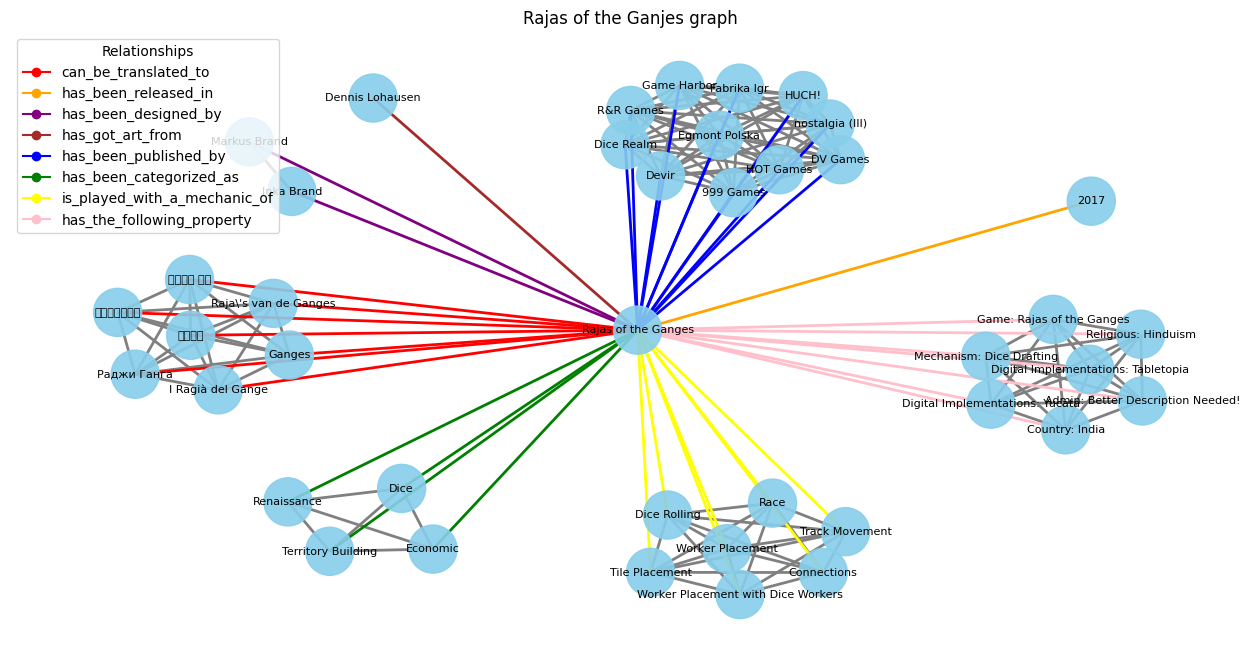

In [29]:
# Crear un grafo de NetworkX
graph_nx = nx.Graph()

# Extraer nodos y relaciones desde RedisGraph
query = """
MATCH (n)-[r]->(m)
RETURN n.name, n.role, type(r), m.name
"""
result = graph.query(query)

# Construir el grafo en NetworkX
for record in result.result_set:
    source_name = record[0]
    source_role = record[1]
    edge_type = record[2]
    target_name = record[3]
    # Agregar nodos
    graph_nx.add_node(source_name, role=source_role)
    graph_nx.add_node(target_name)

    # Agregar aristas
    graph_nx.add_edge(source_name, target_name, relation=edge_type)

# Posición de nodos
pos = nx.spring_layout(graph_nx, seed=1)

# Nodos
plt.figure(figsize=(16, 8))
node_colors = [
   "skyblue" for node in graph_nx.nodes()
]

nx.draw_networkx_nodes(graph_nx, pos, node_color=node_colors, node_size=1200, alpha=0.9)
nx.draw_networkx_labels(graph_nx, pos, font_size=8, font_color="black")

c = ["red", "orange", "purple", "brown", "blue", "green", "yellow", "pink", "cyan", "lime"]
edges = graph_nx.edges(data=True)

# Asignar colores a las relaciones
relation_colors = {
    relation: c[i % len(c)]
    for i, relation in enumerate(credits_data.keys())
}

# Aristas "same_role"
nx.draw_networkx_edges(
    graph_nx,
    pos,
    edgelist=[(u, v) for u, v, d in edges if d.get("relation") == "same_role"],
    edge_color=relation_colors.get("same_role", "gray"),
    style="solid",
    width=2
)

# Otras aristas
for relation, color in relation_colors.items():
    if relation != "same_role":
        nx.draw_networkx_edges(
            graph_nx,
            pos,
            edgelist=[(u, v) for u, v, d in edges if d.get("relation") == relation],
            edge_color=color,
            style="solid",
            width=2,
        )

plt.legend( handles=[ plt.plot([], [], color=color, marker='o', linestyle="dashed" if label == "same_role" else "solid", label=label)[0]
        for label, color in zip(list(relation_colors.keys()), list(relation_colors.values()))],
    loc="upper left",
    title="Relationships")
plt.title("Rajas of the Ganjes graph")
plt.axis("off")
plt.show()

#### Tríadas ####

In [30]:
# Construimos las tríadas a partir del grafo.
triadas = []
for record in result.result_set:
  if record[1]=="Game":
    t = f"{record[0]} {record[2].replace('_', ' ')} {record[3]}"
    if t not in triadas:
      triadas.append(t)
      print(t)

Rajas of the Ganges can be translated to Ganges
Rajas of the Ganges can be translated to I Ragià del Gange
Rajas of the Ganges can be translated to Raja\'s van de Ganges
Rajas of the Ganges can be translated to Раджи Ганга
Rajas of the Ganges can be translated to ガンジスの藩王
Rajas of the Ganges can be translated to 恆河王侯
Rajas of the Ganges can be translated to 갠지스의 라자
Rajas of the Ganges has been released in 2017
Rajas of the Ganges has been designed by Inka Brand
Rajas of the Ganges has been designed by Markus Brand
Rajas of the Ganges has got art from Dennis Lohausen
Rajas of the Ganges has been published by HUCH!
Rajas of the Ganges has been published by 999 Games
Rajas of the Ganges has been published by Devir
Rajas of the Ganges has been published by Dice Realm
Rajas of the Ganges has been published by DV Games
Rajas of the Ganges has been published by Egmont Polska
Rajas of the Ganges has been published by Fabrika Igr
Rajas of the Ganges has been published by Game Harbor
Rajas of the

# Step 2: Classifier #

En esta sección compararemos dos clasificadores, para poder afinar la búsqueda de contexto en el chatbot final. El input será la pregunta del usuario, y ésta caerá en una de las siguientes categorías: rules, revie, stats, related_games y related_data. Cada una de estas clases relacionada a la información recolectada anteriormente.

Con ayuda de ChatGPT, generamos preguntas para probar nuestros modelos.

In [2]:
# Define categories and prompts explicitly
mock_data = [
    # Rules category
    ("What are the rules for placing workers in Rajas of the Ganges?", "rules"),
    ("How does the river mechanic work in Rajas of the Ganges?", "rules"),
    ("Can you explain the scoring system in Rajas of the Ganges?", "rules"),
    ("What happens if two players tie in Rajas of the Ganges?", "rules"),
    ("How do I gain karma in Rajas of the Ganges?", "rules"),
    ("How do I place dice on action spaces in Rajas of the Ganges?", "rules"),
    ("What happens when I run out of money in Rajas of the Ganges?", "rules"),
    ("Can you explain the rules for exchanging goods in Rajas of the Ganges?", "rules"),
    ("What are the restrictions on building placement in Rajas of the Ganges?", "rules"),
    ("How do the different marketplaces work in Rajas of the Ganges?", "rules"),
    ("What are the conditions for advancing along the river track?", "rules"),
    ("Can I choose any building to build in Rajas of the Ganges?", "rules"),
    ("How do I gain karma in Rajas of the Ganges?", "rules"),
    ("How do I gain resources in Rajas of the Ganges?", "rules"),
    ("What happens if I place a worker on a space already occupied?", "rules"),
    ("Can I use a worker multiple times in one round?", "rules"),
    ("How do I use the karma track in Rajas of the Ganges?", "rules"),
    ("What happens if my workers get stuck in Rajas of the Ganges?", "rules"),
    ("How do I upgrade my workers in Rajas of the Ganges?", "rules"),
    ("What is the significance of the palace in Rajas of the Ganges?", "rules"),
    ("How does the taxation mechanic work in Rajas of the Ganges?", "rules"),
    ("Can I perform an action multiple times in a turn?", "rules"),
    ("How does the river and palace tracks impact each other?", "rules"),
    ("Can I block other players from using action spaces?", "rules"),
    ("How do I activate special abilities in Rajas of the Ganges?", "rules"),
    ("How do I handle the bonus tiles in Rajas of the Ganges?", "rules"),
    ("What are the types of workers in Rajas of the Ganges?", "rules"),
    ("What is the importance of dice in the game?", "rules"),
    ("How does the market mechanic work in Rajas of the Ganges?", "rules"),
    ("What determines the value of dice in Rajas of the Ganges?", "rules"),

    # Review category
    ("What do players think of Rajas of the Ganges?", "review"),
    ("Is Rajas of the Ganges a good game for beginners?", "review"),
    ("What are the pros and cons of Rajas of the Ganges?", "review"),
    ("Why do people like Rajas of the Ganges?", "review"),
    ("How does Rajas of the Ganges compare to other worker placement games?", "review"),
    ("What is the best player count for Rajas of the Ganges?", "review"),
    ("Does Rajas of the Ganges have any expansions worth trying?", "review"),
    ("How do the thematic elements contribute to the gameplay experience?", "review"),
    ("What are common criticisms of Rajas of the Ganges?", "review"),
    ("Is Rajas of the Ganges a game that requires deep strategy?", "review"),
    ("How does the balance between luck and strategy work in Rajas of the Ganges?", "review"),
    ("What do players think about the game's length?", "review"),
    ("Is Rajas of the Ganges a good game for casual players?", "review"),
    ("What are the key features that make Rajas of the Ganges enjoyable?", "review"),
    ("How does the player interaction affect the game?", "review"),
    ("What are the most enjoyable aspects of Rajas of the Ganges?", "review"),
    ("Is Rajas of the Ganges suitable for solo play?", "review"),
    ("What kind of players will enjoy Rajas of the Ganges?", "review"),
    ("Is Rajas of the Ganges a good gateway game?", "review"),
    ("What makes the karma track interesting in Rajas of the Ganges?", "review"),
    ("How does the dice mechanic influence gameplay in Rajas of the Ganges?", "review"),
    ("What are common criticisms of Rajas of the Ganges?", "review"),
    ("What is the difficulty level of Rajas of the Ganges?", "review"),
    ("How does Rajas of the Ganges compare to other medium-weight games?", "review"),
    ("What makes Rajas of the Ganges stand out from other worker placement games?", "review"),
    ("What is the most strategic part of Rajas of the Ganges?", "review"),
    ("How does the market mechanic affect decision-making in the game?", "review"),
    ("What are the visual elements of Rajas of the Ganges like?", "review"),
    ("Is Rajas of the Ganges a good game for small groups?", "review"),
    ("What makes the river track mechanic interesting in Rajas of the Ganges?", "review"),

    # Stats category
    ("What is the average rating?", "stats"),
    ("How many ratings have been submitted?", "stats"),
    ("What is the standard deviation of the ratings?", "stats"),
    ("What is the weight score?", "stats"),
    ("How many comments have been made?", "stats"),
    ("How many expansions does Rajas of the Ganges have?", "stats"),
    ("What is the average play time recorded by users?", "stats"),
    ("How many users have favorited Rajas of the Ganges?", "stats"),
    ("What percentage of owners have rated the game?", "stats"),
    ("How does the average rating compare year-over-year?", "stats"),
    ("What is the highest rating for Rajas of the Ganges?", "stats"),
    ("What is the distribution of ratings across different platforms?", "stats"),
    ("How many times has the game been played this year?", "stats"),
    ("How many people have purchased Rajas of the Ganges?", "stats"),
    ("What is the historical trend for Rajas of the Ganges' ratings?", "stats"),
    ("How many players have reviewed the game?", "stats"),
    ("What is the total number of page views?", "stats"),
    ("What is the number of owners who have played the game more than 50 times?", "stats"),
    ("What is the historical strategy rank?", "stats"),
    ("How many comments have been made about gameplay?", "stats"),
    ("How does the number of plays compare to the number of ratings?", "stats"),
    ("What is the number of unique users who rated the game?", "stats"),
    ("How many copies of the game are currently available for trade?", "stats"),
    ("What percentage of ratings come from players who own the game?", "stats"),
    ("How many people want the game in their wishlist?", "stats"),
    ("What is the average number of ratings per month?", "stats"),
    ("How many people have played the game this month?", "stats"),
    ("What is the player satisfaction percentage for Rajas of the Ganges?", "stats"),
    ("How many different editions of the game exist?", "stats"),
    ("What is the average play time recorded by users?", "stats"),

    # Related Games
    ("What games are similar to Rajas of the Ganges?", "related_games"),
    ("Can you recommend games like Rajas of the Ganges?", "related_games"),
    ("Are there any other games by the same designers as Rajas of the Ganges?", "related_games"),
    ("How does Rajas of the Ganges compare to Agricola?", "related_games"),
    ("Is Rajas of the Ganges similar to Stone Age?", "related_games"),
    ("What are some lighter games that feel like Rajas of the Ganges?", "related_games"),
    ("Can you name games with a similar dice mechanics?", "related_games"),
    ("What other games offer a dual-track victory condition?", "related_games"),
    ("Are there other games with Indian themes like Rajas of the Ganges?", "related_games"),
    ("What expansions from other games are comparable to Rajas of the Ganges' gameplay?", "related_games"),
    ("How does Rajas of the Ganges compare to Le Havre?", "related_games"),
    ("What games have a similar worker placement mechanic?", "related_games"),
    ("How does Rajas of the Ganges compare to Tigris & Euphrates?", "related_games"),
    ("How does Rajas of the Ganges compare to Puerto Rico?", "related_games"),
    ("What games feature a karma mechanic like Rajas of the Ganges?", "related_games"),
    ("What games have similar strategies to Rajas of the Ganges?", "related_games"),
    ("Can you compare Rajas of the Ganges to Imperial Settlers?", "related_games"),
    ("How does Rajas of the Ganges compare to Castles of Burgundy?", "related_games"),
    ("What other games feature a river mechanic like Rajas of the Ganges?", "related_games"),
    ("What games have similar dice mechanics to Rajas of the Ganges?", "related_games"),
    ("Are there other games with karma as a mechanic like Rajas of the Ganges?", "related_games"),
    ("How does Rajas of the Ganges compare to Great Western Trail?", "related_games"),
    ("What are some games that focus on economy and expansion like Rajas of the Ganges?", "related_games"),
    ("How does Rajas of the Ganges compare to Gaia Project?", "related_games"),
    ("Is Rajas of the Ganges similar to Stone Age?", "related_games"),
    ("What are some lighter games that feel like Rajas of the Ganges?", "related_games"),
    ("Can you name games with a similar dice mechanics?", "related_games"),
    ("What other games offer a dual-track victory condition?", "related_games"),
    ("How does Rajas of the Ganges compare to Clans of Caledonia?", "related_games"),
    ("What are the best follow-up games after Rajas of the Ganges?", "related_games"),

    # Related Data
    ("What does Rajas of the Ganges translate to in Japanese?", "related_data"),
    ("In which year was Rajas of the Ganges released?", "related_data"),
    ("Who are the designers of Rajas of the Ganges?", "related_data"),
    ("Which artist created the artwork for Rajas of the Ganges?", "related_data"),
    ("Name three publishers of Rajas of the Ganges.", "related_data"),
    ("Which mechanic combines dice and worker placement in Rajas of the Ganges?", "related_data"),
    ("What is the cultural influence behind Rajas of the Ganges?", "related_data"),
    ("Which historical period does Rajas of the Ganges reference?", "related_data"),
    ("What is the production timeline for Rajas of the Ganges?", "related_data"),
    ("How many awards has Rajas of the Ganges won?", "related_data"),
    ("What is the game’s setting in Rajas of the Ganges?", "related_data"),
    ("Which publisher released Rajas of the Ganges?", "related_data"),
    ("What are the board game mechanics in Rajas of the Ganges?", "related_data"),
    ("What does the river mechanic symbolize in the game?", "related_data"),
    ("How many pieces are in the game Rajas of the Ganges?", "related_data"),
    ("What does the palace symbolize in Rajas of the Ganges?", "related_data"),
    ("What is the significance of karma in Rajas of the Ganges?", "related_data"),
    ("What digital platforms have Rajas of the Ganges?", "related_data"),
    ("How does Rajas of the Ganges compare to other economic games?", "related_data"),
    ("What is the significance of dice drafting in Rajas of the Ganges?", "related_data"),
    ("What historical context inspired the theme of Rajas of the Ganges?", "related_data"),
    ("How is territory building handled in Rajas of the Ganges?", "related_data"),
    ("What is the significance of Hinduism in Rajas of the Ganges?", "related_data"),
    ("What mechanic in Rajas of the Ganges is about connecting areas?", "related_data"),
    ("Which mechanic combines dice and worker placement in Rajas of the Ganges?", "related_data"),
    ("What is the cultural influence behind Rajas of the Ganges?", "related_data"),
    ("Which historical period does Rajas of the Ganges reference?", "related_data"),
    ("What is the game Rajas of the Ganges about?", "related_data"),
    ("What is the mechanism of tile placement in Rajas of the Ganges?", "related_data"),
    ("Which company produces the digital version of Rajas of the Ganges?", "related_data"),
]


# Create the DataFrame
training_data = pd.DataFrame(mock_data, columns=["prompt", "type"])

# Display the DataFrame
training_data

,prompt,type
0,What are the rules for placing workers in Raja...,rules
1,How does the river mechanic work in Rajas of t...,rules
2,Can you explain the scoring system in Rajas of...,rules
3,What happens if two players tie in Rajas of th...,rules
4,How do I gain karma in Rajas of the Ganges?,rules
...,...,...
145,What is the cultural influence behind Rajas of...,related_data
146,Which historical period does Rajas of the Gang...,related_data
147,What is the game Rajas of the Ganges about?,related_data
148,What is the mechanism of tile placement in Raj...,related_data


## Random Forest Model##

In [ ]:
# Convertir las preguntas (prompts) en vectores de características usando TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(training_data['prompt'])

# Las etiquetas son las categorías
y = training_data['type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Evaluar el modelo
y_pred = random_forest.predict(X_test)

# Mostrar las estadísticas de evaluación
print(classification_report(y_test, y_pred))


In [ ]:
# TESTING
prompt = ["What is the importance of karma in Rajas of the Ganges?"]
embedded = vectorizer.transform(prompt)
prediction = random_forest.predict(embedded)
print("Prediction:", prediction[0])

prompt = ["How many people plays the game?"]
embedded = vectorizer.transform(prompt)
prediction = random_forest.predict(embedded)
print("Prediction:", prediction[0])


## LLM Model ##

In [29]:
types=["rules", "review", "stats", "related_games", "related_data"]

client = InferenceClient(api_key=userdata.get('HF_TOKEN'))
role="user"
content = f"""You are an expert assistant for a board game called Rajas of the Ganges.
Your task is to classify the provided prompt (usually a question) into exactly one of the following five categories:
- **rules**: If the question is about how to play the game or its gameplay mechanics.
- **review**: If the question is about people’s opinions, reviews, or impressions of the game.
- **stats**: If the question concerns game statistics, such as the number of players, monthly players, or purchase counts.
- **related_games**: If the question is about games similar to this one or asking for recommendations related to it.
- **related_data**: If the question pertains to publishers, designers, release year, translations, properties, or other miscellaneous data related to the game.

### Instructions:
- Your response must be a single word matching one of the above categories.
- Respond with only one category name: 'rules', 'review', 'stats', 'related_games', or 'related_data'.
- Do not include any additional text, explanations, or formatting in your response.

This is the question you should classify:
"""


def llm_classifier(prompt):
  message=[{"role": role, "content": content+prompt}]
  completion = client.chat.completions.create(model="Qwen/Qwen2.5-72B-Instruct", messages=message, max_tokens=50)
  classification = completion.choices[0].message.content.strip()
  if str(classification) not in types:
    print(f"Random classification, llm clasified {classification}.")
    classification = types[len(prompt)%3]
  print(classification.lower())
  return classification.lower()

print(llm_classifier("What other games feature a river mechanic like Rajas of the Ganges?"))

Random classification, llm clasified 0 respect:0 helpful respect:09几个人, June minutesÿ perman Con's your0, the0, reviewing,0,Leave,,),Th helpful respect, this Medical几个人, June minutes,0 Post's your.erase, the instruction.
review
review


Obtenemos las estadísticas también para el LLM.

In [ ]:
accuracy=0
class_precision=0
precisions=[]
for i in range(training_data.shape[0]):
  llm_prediction = llm_classifier(training_data["prompt"][i])
  time.sleep(1)
  if llm_prediction==training_data["type"][i]:
    accuracy+=1
    class_precision+=1
  if i==29 or i==59 or i==89 or i==119 or i==149:
    precisions.append(class_precision/30)
    class_precision=0

print(accuracy/training_data.shape[0])
print(f"Precisions: {precisions}")

In [ ]:
# Workaround por un error en el cálculo, para evitar volver a correr el código, ignorar después
"""for i in range(len(precisions)):
  precisions[i] = precisions[i]*25/30
  precisions[i] = round(precisions[i], 2)
print(precisions)
"""

# Step 3: Retriever #

En esta sección definiremos nuestro reranker, que nos permitirá limitar la cantidad de chunks a leer, en base al input del usuario. El reranker se utilizará para la base de datos vectorial, y para el resto de bases de datos, se proporcionará la totalidad del contexto.

## Retrievers y Reranker ##

In [9]:
!pip install txtai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.3/256.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 64.2 MB/s eta 0:00:00


In [10]:
from txtai.scoring import ScoringFactory

In [24]:
# Crear un índice BM25 con los chunks
scoring = ScoringFactory.create({"method": "bm25", "terms": True})
scoring.index(((x, texto, None) for x, texto in enumerate(chunks)))

# Definimos una función que busque por palabras clave, con el método BM25.
def search_keywords(query:str):
  resultados = scoring.search(query, 1)
  if resultados:
    coincidencia = chunks[resultados[0][0]]
    return coincidencia
  else:
    return None


In [25]:
print(search_keywords("amount of players"))

on the opposite side is for three and four just because of some of the spaces theres a little bit more space right and so in terms of player count how do you feel uh plays well at all player counts yeah we played at all players we have played at all player accounts uh where is my favorite maybe three i want to say maybe uh it plays very well at two though its nice to be able to go you know back to back i will say that when higher player counts theres the same amount of tiles out there and so


Vamos a ver cómo se comporta nuestro retriever con palabras claves relacionadas al juego.

In [26]:
keywords = ["start new game", "amount of players", "opinions", "review", "developer", "board game"]

In [27]:
for kw in keywords:
  print("-"*50)
  print(f"Key Word: {kw}")
  print(f"Chunk retrieved: {search_keywords(kw)}")

--------------------------------------------------
Key Word: start new game
Chunk retrieved: lets talk about it sure so this is rogers at the guarantees this is not a new game it was released what year was this release i think 2017 a few years ago and uh its not even a shelf of shame like this uh typically once a month or we will do a shelf of shame video for the patreon but uh this is a game that was requested just off of our shelf that we have already really loved yep exactly so lets talk about it now that ive spilled the beef or how we feel about it yeah well this is one from our
--------------------------------------------------
Key Word: amount of players
Chunk retrieved: on the opposite side is for three and four just because of some of the spaces theres a little bit more space right and so in terms of player count how do you feel uh plays well at all player counts yeah we played at all players we have played at all player accounts uh where is my favorite maybe three i want to sa

Veamos cómo se comporta ahora con las preguntas de prueba.

In [28]:
for i in range(10):
  q = training_data["prompt"][i*10]
  print("-"*50)
  print(f"Question: {q}")
  print(f"Chunk retrieved: {search_keywords(q)}")


--------------------------------------------------
Question: What are the rules for placing workers in Rajas of the Ganges?
Chunk retrieved: this game um replayability may not be there but thats not a bad thing theres many games out there so i can always put this on the shelf come back to it three months later and have a great fantastic time yes we do keep a few games on our shelf as long term games that are exactly like that we cant play them back to back but we love them every time we do bring it out exactly so that is rajas of the ganges thank you so much to our patreon supporters for uh recommending this game to play uh it had
--------------------------------------------------
Question: What are the conditions for advancing along the river track?
Chunk retrieved: and so there is no physical money in this game whenever we spend and earn money we just progress our marker along this track on the opposite side of the board starts the fame track and that is kind of like this golden fan 

In [ ]:
from sentence_transformers import CrossEncoder
import chromadb

class Reranker:
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        # Inicializa el reranker con un modelo de cross-encoder.
        self.model = CrossEncoder(model_name)

    def rerank(self, query: str, nodes, top_k: int = None) -> list:
        # Reordena los nodos utilizando el cross-encoder.
        if not nodes:
            return nodes

        pairs = [(query, node) for node in nodes]
        scores = self.model.predict(pairs)
        scored_nodes = list(zip(scores, nodes))
        scored_nodes.sort(key=lambda x: x[0], reverse=True)

        if top_k:
            scored_nodes = scored_nodes[:top_k]

        return [node for _, node in scored_nodes]

"""
def search_keywords(query: str, nodes, top_k: int = None) -> list:
    # Realiza una búsqueda por palabras clave. Filtra los documentos que contienen las palabras clave.
    filtered_nodes = [node for node in nodes if query.lower() in node.lower()]
    if top_k:
        filtered_nodes = filtered_nodes[:top_k]

    return filtered_nodes
"""



def retriever_vector_db(prompt, **kwargs):
    reranker = Reranker()

    # Realiza una búsqueda por palabras clave en los documentos disponibles.
    results = vector_db.query(query_texts=[prompt], n_results=10)  # Recupera más resultados para el reranking
    nodes = [doc[0] for doc in results['documents']]  # Extrae los documentos

    # Búsqueda por palabras clave
    keyword_results = search_keywords(prompt)

    # Búsqueda semántica
    semantic_results = reranker.rerank(prompt, nodes)

    # Combinación de resultados (en este caso, unifica los dos conjuntos de resultados sin duplicados)
    hybrid_results = list(set([keyword_results] + semantic_results))

    # Limitar el número de resultados si se especifica
    top_k = kwargs.get('top_k', None)
    if top_k:
        hybrid_results = hybrid_results[:top_k]

    return hybrid_results[0] if hybrid_results else None


"""
def retriever_vector_db(prompt, **kwargs):
    reranker = Reranker()

    # Retrieves the most relevant document from the vector database.
    results = vector_db.query(query_texts=[prompt], n_results=10)  # Retrieve more results for reranking
    nodes = [doc[0] for doc in results['documents']]  # Extract documents

    if reranker:
        # Apply reranking if a reranker is provided.
        nodes = reranker.rerank(prompt, nodes)

    return nodes[0] if nodes else None
"""



def retriever_dataframe_db(**kwargs):
  context = game_stats()
  return context

def retriever_graph_db(**kwargs):
  same_developer = games_same_developer()
  same_publisher = games_same_publisher()
  context = same_developer+"\n"+same_publisher
  return context

def retriever_related_data(**kwargs):
  context=""
  for t in triadas:
      context = context + t + ". "
  return context

# This function calls the ones already defined, and provide the appropriate context for an specific prompt.
def retriever(prompt):
  classification = llm_classifier(prompt)

  if classification=="rules":
    context = retriever_vector_db(prompt)
    return context
  elif classification=="review":
    context = retriever_vector_db(prompt)
    return context
  elif classification=="stats":
    context = retriever_dataframe_db()
    return context
  elif classification=="related_games":
    context = retriever_graph_db()
    return context
  elif classification=="related_data":
    context = retriever_related_data()
    return context
  else:
    print("Clasification failed. Sending vector db context.")
    context = retriever_vector_db(prompt)
    return context

Realizamos pruebas para ver cómo funciona el reranker y el clasificador.

In [ ]:
# TEST - EJECUCIÓN PREVIA A LA BÚSQUEDA HÍBRIDA

# Initialize the reranker
print('Initializing reranker...')


# Example usage
print("----------------------------------------")
query = "How should I start the game board?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How was this game rated by the community?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "What is the game's average rating?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How many monthly players does this game have?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "Can you recommend a similar game?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How is this game called in spanish?"
context = retriever(query)
print("Retrieved context:", context)

In [ ]:
# TEST - EJECUCIÓN CON BÚSQUEDA HÍBRIDA
# Initialize the reranker
print('Initializing reranker...')


# Example usage
print("----------------------------------------")
query = "How should I start the game board?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How was this game rated by the community?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "What is the game's average rating?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How many monthly players does this game have?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "Can you recommend a similar game?"
context = retriever(query)
print("Retrieved context:", context)

print("----------------------------------------")
query = "How is this game called in spanish?"
context = retriever(query)
print("Retrieved context:", context)

# Step 4: Prompt Preparation #

En esta sección prepararemos el prompt para poder llamar a nuestro chatbot, con el contexto apropiado, y además haremos el manejo de lenguaje para que funcione tanto en español como en inglés.

## Language Manager ##

In [ ]:
def isSpanish(input):
  idioma = detect(input)
  if idioma=="es":
    return True
  elif idioma=="en":
    return False
  else:
    return None

print(isSpanish("Hola, ¿cómo estás?"))
print(isSpanish("Hello, how are you?"))

translated = GoogleTranslator(source='en', target='es').translate('I want to translate this text')
print(translated)


def translate_to_english(content):
  if type(content)==str:
    translated = GoogleTranslator(source='es', target='en').translate(content)
    return translated
  else:
    return None

def translate_to_spanish(content):
  if type(content)==str:
    translated = GoogleTranslator(source='en', target='es').translate(content)
    return translated
  else:
    return None

print(translate_to_english("Hola, mi nombre es Francisco."))
print(translate_to_spanish("Hello, my name is Francisco."))

## Prompt and execution ##

Proveemos de un prompy simple y conciso con toda la información requerida para responder las preguntas del usuario.

In [ ]:
def prompt_prep(context, user_input):
  query = f"""You're helping an end user with a board game called Rajas of the Ganges.
  You're a subject matter expert that will provide an answer to, ideally, a single question from this user.
  Your answer has to be as much direct and consistant as possible.
  If the context available is not enough to answer the question, ask the end user to reformulate the question.
  This is the context available:
  {context}
  This is the end user question:
  {user_input}
  """
  return query

def generate_answer(context, user_input):
    # Generates an answer to the given query based on the provided context using the specified model.
    client = InferenceClient(api_key=userdata.get('HF_TOKEN'))  # Initialize the inference client

    model = "Qwen/Qwen2.5-72B-Instruct"
    max_tokens=100

    try:
        # Build the prompt with the query and context
        prompt = prompt_prep(context, user_input)

        # Request a response from the model
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=0.7,
            top_p=0.95
        )

        # Extract and return the generated content
        return response.get('choices', [{}])[0].get('message', {}).get('content', "")

    except Exception as error:
        # Handle any errors that occur during the process
        return "An error occurred while processing your request."

In [ ]:
def help(question=None):
  print("Rajas of the Ganges - HELP!")

  if question and type(question)==str:
    user_input=question
  else:
    user_input = str(input("Ask me something: "))

  if isSpanish(user_input):
    print("Así que hablas español. Deja que me preparo para la ocasión. *se prepara un mate*")
    user_input_english = translate_to_english(user_input)

    print("Buscando en esta base de datos:")
    context = retriever(user_input_english)
    output = generate_answer(context, user_input_english)
    output_spanish = translate_to_spanish(output)

    print("Mi respuesta: ")
    print(output_spanish)
  else:
    print("Searching in this database:")
    context = retriever(user_input)

    print("Let me think...")
    output = generate_answer(context, user_input)

    print("This is my answer: ")
    print(output)

Probamos manualmente el chatbot.

#### Antes de la búsqueda por palabras claves ####

In [ ]:
help()

Y también de forma autónoma, haciendo uso de su argumento opcional "pompt", con preguntas tanto en inglés como en español.

In [ ]:
questions = [
    "What are the rules for placing workers in Rajas of the Ganges?",
    "¿Cómo funciona la mecánica del río en Rajas of the Ganges?",
    "Can you explain the scoring system in Rajas of the Ganges?",
    "¿Qué piensan los jugadores de Rajas of the Ganges?",
    "Is Rajas of the Ganges a good game for beginners?",
    "¿Cuáles son los pros y contras de Rajas of the Ganges?",
    "What is the average rating?",
    "¿Cuántas valoraciones se han enviado?",
    "What is the standard deviation of the ratings?",
    "¿Qué juegos son similares a Rajas of the Ganges?",
    "Can you recommend games like Rajas of the Ganges?",
    "¿Hay otros juegos de los mismos diseñadores de Rajas of the Ganges?",
    "What does Rajas of the Ganges translate to in Japanese?",
    "¿En qué año se lanzó Rajas of the Ganges?",
    "Who are the designers of Rajas of the Ganges?"
]

In [ ]:
for q in questions:
  print("---------------------------------------------")
  print(q)
  help(q)

#### Con búsqueda por palabras claves ####

In [ ]:
help()

In [ ]:
for q in questions:
  print("---------------------------------------------")
  print(q)
  help(q)

# Ejercicio 2: Agente Inteligente #

En este ejercicio programaremos un agente inteligente que interactúe con un usuario final, y sirva a los mismos fines que el chatbot antes mencionado. Para ello haremos uso del LLM de Ollama.

Para el contexto, reutilizaremos las funciones antes definidas (retrievers). Para el único retriever con input (el de la base de datos vectorial) definiremos un wrapper para usar los métodos provistos por Ollama.

In [ ]:
# Ollama
!curl -fsSL https://ollama.com/install.sh | sh

!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh

# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &
!ollama pull llama3.2 > ollama.log
!pip install llama-index-llms-ollama llama-index
!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &

Con este sleep evitamos que se intente importar las librerías antes de que las instalaciones tengan impacto en el entorno de ejecución.

In [ ]:
time.sleep(20)

In [ ]:
# Ollama
from llama_index.core.tools import FunctionTool
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.react.formatter import ReActChatFormatter

In [ ]:
def retriever_vector_db_wrapper(input_data, **kwargs):
    # Extract the `prompt` and `kwargs` from the input_data dictionary
    prompt = input_data.get("prompt", "")
    kwargs = input_data.get("kwargs", {})

    # Call the original retriever_vector_db function with the correct arguments
    return retriever_vector_db(prompt, **kwargs)

Definimos la función que llama al agente, con un prompt específico para la tarea que se le solicita, con los retrievers como tools para proveerlo del contexto adecuado.

In [ ]:
def agent_help():
  print("Rajas of the Ganges - AGENT HELP!")
  user_input = str(input("Ask me something: "))

  # LLM Setup
  llm = Ollama(model="llama3.2:latest", request_timeout=100, temperature=0.1, context_window=4000)
  Settings.llm = llm

  # Creating tools
  tools = [FunctionTool.from_defaults(fn=retriever_vector_db_wrapper, description="Information about rules and reviews."),
  FunctionTool.from_defaults(fn=retriever_dataframe_db, description="Information about game statistics."),
  FunctionTool.from_defaults(fn=retriever_graph_db, description="Information about related games."),
  FunctionTool.from_defaults(fn=retriever_related_data, description="Information about related data."),
  ]

  # Crear el agente ReAct
  agent = ReActAgent.from_tools(
      tools,
      llm=llm,
      verbose=True,
      max_iterations=15,
      chat_formatter=ReActChatFormatter(),
      system_prompt=
      """"
      You're helping an end user with a board game called Rajas of the Ganges.
      You're a subject matter expert that will provide an answer to, ideally, a single question from this user.
      Your answer has to be as much direct and consistant as possible.
      If the context available is not enough to answer the question, ask the end user to reformulate the question.

      You must follow this format:

      Thought: Here, I explain what I need to do.
      Action: nameOfTheTool
      Action Input: "user prompt"

      ## Correct examples:
      - For retriever_vector_db: Action Input: "user prompt"
      - For retrieve_dataframe: Action Input: "user prompt"
      - For retrieve_graph: Action Input: "user prompt"
      - For retriever_related_data: Action Input: "user prompt"

      ## Observation: [Result of the tool]
      ... [Repeat process if necessary]
      Final Answer: The best answer you found.

      ## For each query:
      1. Analyze which information do you need.
      2. Use the available tools.
      3. Return the answer that best answers the query.

      ## IMPORTANT:
      - The action input is **always** the user prompt
      - Never modify the user prompt
      - Always follow the exact format of the examples for each tool.

      # Example Interaction:
      ## Query 1:
      "How many players do I need to start a new game?"
      Thought: I need to find information about the number of players needed to start a new game.
      Action: retriever_vector_db
      Action Input: "How many players do I need to start a new game?"
      Observation: "2 to 4 players"
      Final Answer: "You need 2 to 4 players to start a new game."

      ## Query 2:
      "How many monthly players does this game have?"
      Thought: I need to find information about the statistics of the game.
      Action: retriever_dataframe_db
      Action Input: "How many monthly players does this game have?"
      Observation: "Monthly Players: 522"
      Final Answer: "This game has 522 monthly players."

      ## Query 3:
      "Who published this game?"
      Thought: I need to find data related to this game.
      Action: retriever_related_data
      Action Input: "Who published this game?"
      Observation: Hasbro
      Final Answer: The game was published by Hasbro.
      """,
      react_chat_history=False,
      context="""
      You are a helpful assistant who always responds with truthful, helpful and fact-based answers.
      You are an expert in board games and understand their descriptive characteristics.
      Remember the outputs of the tools to use them in your final answer.
      """)

  try:
      if not user_input.strip():
          return "The query is empty."
      response = agent.chat(user_input)
  except Exception as e:
      response = f"Error processing the query: {str(e)}"


  print(f"\nAnswer: {response}")
  print("\n\n")

Realizamos pruebas para analizar el comportamiento del agente a diferentes escenarios posibles.

In [ ]:
client = InferenceClient(api_key=userdata.get('HF_TOKEN'))
## This code was run before manually adding the max iterations.
agent_help()

In [ ]:
## This code was run before adding the action input again in the code.
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
## This code was run before adding the wrapper.
agent_help()

In [ ]:
# This code was run before adding kwargs to the wrapping
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()

In [ ]:
agent_help()